### Libraries Import

In [2]:
# Importa todas as bibliotecas
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import os
import nrrd
import torch
import torch.nn as nn
from monai.data import Dataset, DataLoader
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Spacingd,
    Orientationd,
    ResizeWithPadOrCropd,
    ScaleIntensityRanged,
    RandRotated,
    RandFlipd,
    EnsureTyped
)
from monai.networks.nets import ViT
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import wandb
from wandb.integration.keras import WandbMetricsLogger

c:\Users\Gabriel Panza\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


### Aux. Functions

In [3]:
def load_data(image_dir, mask_dir):
    """
    Encontra e pareia os caminhos das imagens com suas 
    respectivas máscaras de segmentação.
    """
    file_list = []

    # Garante que os arquivos estão ordenados para o pareamento correto
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for image_file, mask_file in zip(image_files, mask_files):
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_file)
        
        if os.path.exists(mask_path):
            # Ler a máscara para determinar o rótulo
            mask_itk = sitk.ReadImage(mask_path)
            mask_np = sitk.GetArrayFromImage(mask_itk)
            
            # O rótulo é 1 se houver qualquer pixel não-zero na máscara, senão 0
            label = 1 if np.sum(mask_np) > 0 else 0
            
            file_list.append({
                "image": image_path,
                "mask": mask_path,
                "label": label
            })
        else:
            print(f"Aviso: Máscara não encontrada para {image_path}")
            
    return file_list

In [4]:
# Definir as transformações de pré-processamento
# 'image' é a chave que demos no nosso dicionário de arquivos
keys = ["image"] 
IMG_SIZE = (128, 128, 128) # Tamanho padrão para o qual redimensionaremos os volumes

train_transforms = Compose(
    [
        LoadImaged(keys=keys),
        EnsureChannelFirstd(keys=keys),
        # Reorienta para um padrão (ex: RAS)
        Orientationd(keys=keys, axcodes="RAS"),
        # Ajusta o espaçamento entre voxels
        Spacingd(keys=keys, pixdim=(1.0, 1.0, 1.0), mode=("bilinear")),
        # Normaliza a intensidade dos pixels para o intervalo [0, 1]
        ScaleIntensityRanged(
            keys=keys, a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        # Redimensiona ou preenche para o tamanho alvo
        ResizeWithPadOrCropd(keys=keys, spatial_size=IMG_SIZE),
        # Data Augmentation
        RandRotated(keys=keys, range_x=0.1, range_y=0.1, range_z=0.1, prob=0.2),
        RandFlipd(keys=keys, spatial_axis=[0], prob=0.5),
        EnsureTyped(keys=keys)
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=keys),
        EnsureChannelFirstd(keys=keys),
        Orientationd(keys=keys, axcodes="RAS"),
        Spacingd(keys=keys, pixdim=(1.0, 1.0, 1.0), mode=("bilinear")),
        ScaleIntensityRanged(
            keys=keys, a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        ResizeWithPadOrCropd(keys=keys, spatial_size=IMG_SIZE),
        EnsureTyped(keys=keys)
    ]
)

In [5]:
# Função de plot do treinamento do modelo
def plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    # Criar a figura para os plots
    plt.figure(figsize=(14, 6))

    # Plotar o histórico de Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Loss de Treino')
    plt.plot(val_loss_history, label='Loss de Validação')
    plt.title("Histórico de Loss")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Plotar o histórico de Acurácia
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Acurácia de Treino')
    plt.plot(val_acc_history, label='Acurácia de Validação')
    plt.title("Histórico de Acurácia")
    plt.xlabel("Épocas")
    plt.ylabel("Acurácia")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Main Loop

In [6]:
# Carregar os pares de caminhos
IMAGE_DIR = "Patients_Displasya/T1"
MASK_DIR = "Mascaras"
file_list = load_data(IMAGE_DIR, MASK_DIR)

In [7]:
# Verificar o balanceamento das classes
labels = [item['label'] for item in file_list]
print(f"Total de amostras encontradas: {len(file_list)}")
print(f"Amostras com lesão (label 1): {np.sum(labels)}")
print(f"Amostras saudáveis (label 0): {len(labels) - np.sum(labels)}")

train_files, test_files = train_test_split(file_list, test_size=0.1, random_state=42, stratify=labels)
train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42, stratify=[item['label'] for item in train_files])

print(f"Amostras de treino: {len(train_files)}")
print(f"Amostras de validação: {len(val_files)}")
print(f"Amostras de teste: {len(test_files)}")

Total de amostras encontradas: 41
Amostras com lesão (label 1): 41
Amostras saudáveis (label 0): 0
Amostras de treino: 28
Amostras de validação: 8
Amostras de teste: 5


In [8]:
# Definir as transformações de pré-processamento
# 'image' é a chave que demos no nosso dicionário de arquivos
keys = ["image"] 
IMG_SIZE = (128, 128, 128) # Tamanho padrão para o qual redimensionaremos os volumes

train_transforms = Compose(
    [
        LoadImaged(keys=keys),
        EnsureChannelFirstd(keys=keys),
        # Reorienta para um padrão (ex: RAS)
        Orientationd(keys=keys, axcodes="RAS"),
        # Ajusta o espaçamento entre voxels
        Spacingd(keys=keys, pixdim=(1.0, 1.0, 1.0), mode=("bilinear")),
        # Normaliza a intensidade dos pixels para o intervalo [0, 1]
        ScaleIntensityRanged(
            keys=keys, a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        # Redimensiona ou preenche para o tamanho alvo
        ResizeWithPadOrCropd(keys=keys, spatial_size=IMG_SIZE),
        # Data Augmentation
        RandRotated(keys=keys, range_x=0.1, range_y=0.1, range_z=0.1, prob=0.2),
        RandFlipd(keys=keys, spatial_axis=[0], prob=0.5),
        EnsureTyped(keys=keys)
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=keys),
        EnsureChannelFirstd(keys=keys),
        Orientationd(keys=keys, axcodes="RAS"),
        Spacingd(keys=keys, pixdim=(1.0, 1.0, 1.0), mode=("bilinear")),
        ScaleIntensityRanged(
            keys=keys, a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        ResizeWithPadOrCropd(keys=keys, spatial_size=IMG_SIZE),
        EnsureTyped(keys=keys)
    ]
)

# Criar os Datasets
# A chave "label" será passada diretamente
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)

# Criar os DataLoaders
# Ajuste o batch_size conforme a VRAM da sua GPU
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=4, num_workers=4)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViT(
    in_channels=1,
    img_size=IMG_SIZE,
    patch_size=(32, 32, 32),
    classification=True,
    num_classes=2,
    dropout_rate=0.1,
).to(device)

In [10]:
# Hiperparâmetros
learning_rate = 0.001   
num_epochs = 100

# Função de perda e otimizador
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Listas para armazenar o histórico
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# --- LOOP DE TREINAMENTO ---
best_val_acc = 0.0
for epoch in range(num_epochs):
    print(f"--- Epoch {epoch + 1}/{num_epochs} ---")
    
    # --- Treinamento ---
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch_data in train_loader:
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)[0]
        
        # Calcular loss
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        
        # Calcular acurácia de treino
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_accuracy = train_correct / train_total
    
    # Salvar histórico de treino
    train_loss_history.append(avg_train_loss)
    train_acc_history.append(train_accuracy)
    
    print(f"Loss de Treino: {avg_train_loss:.4f} | Acurácia de Treino: {train_accuracy:.4f}")
    
    # --- Validação ---
    model.eval()
    epoch_val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_data in val_loader:
            images, labels = val_data["image"].to(device), val_data["label"].to(device)
            outputs = model(images)[0]
            
            # Calcular loss de validação
            loss = loss_function(outputs, labels)
            epoch_val_loss += loss.item()
            
            # Calcular acurácia de validação
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    
    # Salvar histórico de validação
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_accuracy)

    print(f"Loss de Validação: {avg_val_loss:.4f} | Acurácia de Validação: {val_accuracy:.4f}")
    
    # Salvar o melhor modelo
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), "best_vit_model.pth")
        print("Modelo salvo!")

print("Treinamento concluído.")

--- Epoch 1/100 ---
Loss de Treino: 0.1777 | Acurácia de Treino: 1.0000
Loss de Validação: 0.1269 | Acurácia de Validação: 1.0000
Modelo salvo!
--- Epoch 2/100 ---
Loss de Treino: 0.1269 | Acurácia de Treino: 1.0000
Loss de Validação: 0.1269 | Acurácia de Validação: 1.0000
--- Epoch 3/100 ---
Loss de Treino: 0.1269 | Acurácia de Treino: 1.0000
Loss de Validação: 0.1269 | Acurácia de Validação: 1.0000
--- Epoch 4/100 ---
Loss de Treino: 0.1269 | Acurácia de Treino: 1.0000
Loss de Validação: 0.1269 | Acurácia de Validação: 1.0000
--- Epoch 5/100 ---
Loss de Treino: 0.1269 | Acurácia de Treino: 1.0000
Loss de Validação: 0.1269 | Acurácia de Validação: 1.0000
--- Epoch 6/100 ---
Loss de Treino: 0.1269 | Acurácia de Treino: 1.0000
Loss de Validação: 0.1269 | Acurácia de Validação: 1.0000
--- Epoch 7/100 ---
Loss de Treino: 0.1269 | Acurácia de Treino: 1.0000
Loss de Validação: 0.1269 | Acurácia de Validação: 1.0000
--- Epoch 8/100 ---
Loss de Treino: 0.1269 | Acurácia de Treino: 1.0000
Loss

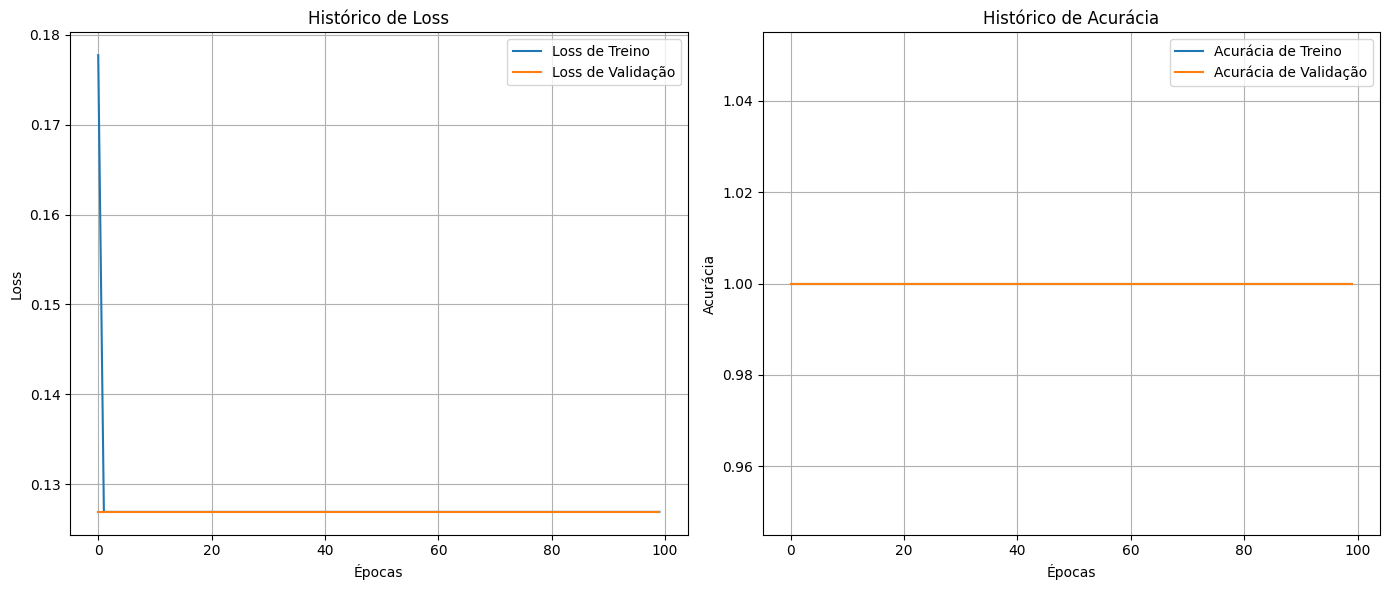

In [11]:
plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

              precision    recall  f1-score   support

   Displasia       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.


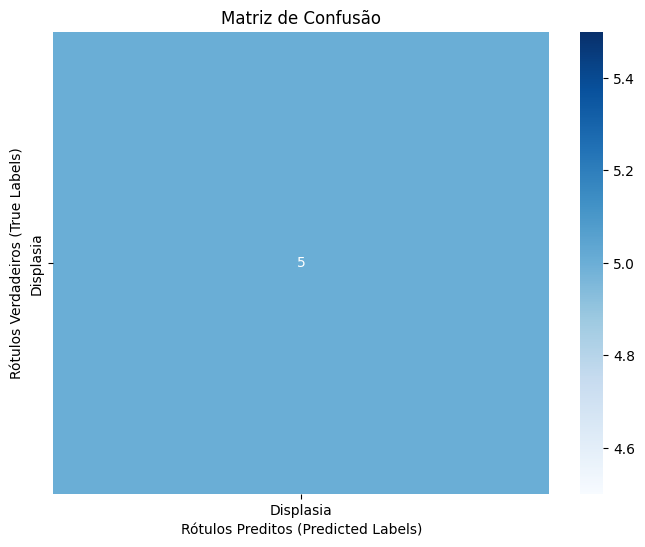

In [ ]:
# Carregar o melhor modelo
model.load_state_dict(torch.load("best_vit_model.pth"))
model.to(device)
model.eval()

# Criar DataLoader de teste (usando as mesmas transformações de validação)
test_ds = Dataset(data=test_files, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

y_true = []
y_pred = []

with torch.no_grad():
    for test_data in test_loader:
        images, labels = test_data["image"].to(device), test_data["label"].to(device)
        outputs = model(images)[0]
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 1. Exibir o relatório de classificação
target_names = ["Saudável", "Displasia"]
print(classification_report(y_true, y_pred, target_names=target_names))

# 2. Calcular e plotar a Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusão')
plt.ylabel('Rótulos Verdadeiros (True Labels)')
plt.xlabel('Rótulos Preditos (Predicted Labels)')
plt.show()
